Setup
Let's start by specifying:

The S3 bucket and prefix to use for training and model data. All in us-east-1
The IAM role arn used to give training and hosting access to your data - was created at time of Notebook creation


In [8]:
##Setup
import sagemaker
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'sagemakerbankfraud-xgboost'

# Define IAM role

import re
from sagemaker import get_execution_role

role = get_execution_role()

In [10]:
###dowload all files form s3 bucket into local os
import boto3
s3 = boto3.resource('s3') # assumes credentials & configuration are handled outside python in .aws directory or environment variables

def download_s3_folder(bucket_name, s3_folder, local_dir=None):
    """
    Download the contents of a folder directory
    Args:
        bucket_name: the name of the s3 bucket
        s3_folder: the folder path in the s3 bucket
        local_dir: a relative or absolute directory path in the local file system
    """
    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=s3_folder):
        target = obj.key if local_dir is None \
            else os.path.join(local_dir, os.path.relpath(obj.key, s3_folder))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)

data_bucket = 'blackbelt-mk'
data_prefix = 'csv-files'
        
download_s3_folder(data_bucket,data_prefix)   

In [12]:
###test data pull of one of the files
f = pd.read_csv('csv-files/run-1609786653434-part-r-00000')
f.head()

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud,partition_0,partition_1,partition_2
0,336,PAYMENT,2300.83,C1155634657,490068.0,487767.17,M1752906875,0.00,0.00,0,0,12,24,3
1,336,PAYMENT,14315.64,C2143154786,212.0,0.00,M1327521230,0.00,0.00,0,0,12,24,3
2,336,TRANSFER,1623318.20,C119965526,0.0,0.00,C476460499,4760087.35,6383405.55,0,0,12,24,3
3,336,PAYMENT,4330.56,C915405613,1047.0,0.00,M640758140,0.00,0.00,0,0,12,24,3
4,336,PAYMENT,12957.05,C1806878297,155617.0,142659.95,M1486745678,0.00,0.00,0,0,12,24,3


In [13]:
###read each download file into a single CSV file
import os, glob
import csv
import pandas as pd # For munging tabular data

file_location = os.path.join('csv-files', '*')
filenames = glob.glob(file_location)



df_from_each_file = (pd.read_csv(f, sep=',') for f in filenames)
df_merged = pd.concat(df_from_each_file, ignore_index=True)
df_merged.to_csv( "full_data.csv")

In [50]:
###delete non-needed files to save space on os
for f in filenames:
    try:
        os.remove(f)
    except OSError as e:
        print("Error: %s : %s" % (f, e.strerror))

Error: csv-files/run-1609786653434-part-r-00315 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00009 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00035 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00142 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00237 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00200 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00288 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00054 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00172 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00275 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00345 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00271 : No such file or directory
Error: csv-files/run-1609786653434-part-r-00074 : No such file or directory
Error: csv-f

In [51]:
data = df_merged.sort_values("step", ignore_index=True, inplace=True)
data = df_merged.drop_duplicates()
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows',20)


In [92]:
###create unprepoccessed test data
train_datap, validation_datap, test_datap = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data)), int(0.9 * len(data))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%


In [94]:
pd.concat([test_datap['isfraud'], test_datap.drop(['isfraud'], axis=1)], axis=1).to_csv('testpre.csv', index=False, header=False)

In [96]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/testnotprocessed.csv')).upload_file('testpre.csv')

In [52]:
#Import all potential libraries

import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sklearn
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

import seaborn as sns
sns.set_style('white')                            #Set theme for Seaborn
import matplotlib.pyplot as plt                   # For charts and visualizations
import sys                                        # For writing outputs to notebook
import os                                         # For manipulating filepath names
%matplotlib inline

Exploration
Read the data into a Pandas DataFrame to explor

In [185]:
#data = pd.read_csv('./PS_20174392719_1491204439457_log.csv')
#pd.set_option('display.max_columns', 15)
#pd.set_option('display.max_rows',20)

In [186]:
#data

In [53]:
data.info() ###see data types per column 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6365561 entries, 0 to 6365560
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameorig        object 
 4   oldbalanceorg   float64
 5   newbalanceorig  float64
 6   namedest        object 
 7   oldbalancedest  float64
 8   newbalancedest  float64
 9   isfraud         int64  
 10  isflaggedfraud  int64  
 11  partition_0     int64  
 12  partition_1     int64  
 13  partition_2     int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 728.5+ MB


In [54]:
print(data.shape,data.dtypes.groupby(data.dtypes).size()) ##summary of shape and grouped data types

(6365561, 14) int64      6
float64    5
object     3
dtype: int64


Summary Writeup Early Observations

 - 6.36MM bank transactions and 11 features
 - features are majority numerical , Step is considered a unit of time (artifical trend), type is categorical(one hot encoding), nameOrig is an identifier, nameDest is an identifier
 
 - isFraud is the target variable that shows what fraud items have been identified - binary - (we can use this to start with a supervised model) - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
 
 - isFlaggedFraud - he business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
 
 - old and new balance org shows originated bank account balances before and after transactions 
 - old and new balance dest shows destination bank account balanes before and after transactions
 - note : variables that begin with C are customers and M for merchants ( can create a new variable off of this logic)
 - amount is the amount of the transaction
 
 - type is categorical - will one-hot encode but also can do some explantory analysis to see distribution of fraud items per transaction type
 

In [55]:
###Check for missing data
data.isnull().sum()  ## conclusion nothing is missing

data = data.drop(columns=['partition_0','partition_1','partition_2'])##drop glue partition related columns

Explanatory Analysis and Visualizations

In [56]:
data.describe().T ### observe average, ranges and std for all columns

,count,mean,std,min,25%,50%,75%,max
step,6365561.0,2.432885e+02,1.423890e+02,1.0,155.00,239.00,334.00,7.430000e+02
amount,6365561.0,1.798547e+05,6.037591e+05,0.0,13386.39,74855.98,208718.79,9.244552e+07
oldbalanceorg,6365561.0,8.339337e+05,2.888066e+06,0.0,0.00,14212.78,107331.00,5.958504e+07
newbalanceorig,6365561.0,8.551626e+05,2.923875e+06,0.0,0.00,0.00,144288.86,4.958504e+07
oldbalancedest,6365561.0,1.100635e+06,3.398883e+06,0.0,0.00,132615.74,942893.53,3.560159e+08
newbalancedest,6365561.0,1.225042e+06,3.673915e+06,0.0,0.00,214577.93,1111927.85,3.561793e+08
isfraud,6365561.0,1.290224e-03,3.589651e-02,0.0,0.00,0.00,0.00,1.000000e+00
isflaggedfraud,6365561.0,2.513526e-06,1.585408e-03,0.0,0.00,0.00,0.00,1.000000e+00


0    6357348
1       8213
Name: isfraud, dtype: int64


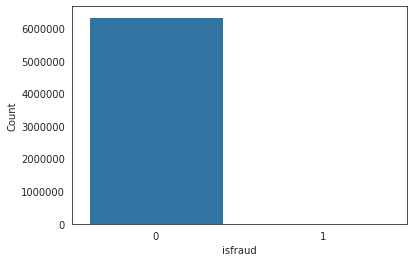

In [57]:
###count number of fraud and non fraud items
print(data.isfraud.value_counts())
sns.countplot(data=data, x='isfraud')
plt.ylabel('Count')
plt.show()

###Results show a very imbalanced dataset - we should look to oversample fraud items using SMOTE (also we can look to create an anamoly detection method later on)


In [58]:
###Count the number of data points per each type of transaction per isFraud
pd.crosstab(data.type, data.isfraud)

###we noticed that fraud transcations only occur for Cashout and Transfer transactions

isfraud,0,1
type,,
CASH_IN,1399895,0
CASH_OUT,2234120,4116
DEBIT,41461,0
PAYMENT,2152748,0
TRANSFER,529124,4097


In [59]:
###determine what isFlagged does
pd.crosstab(data.isfraud, data.isflaggedfraud)

###only 16 items flagged fraud that are fraud - not a very useful variable we can omit from our model

isflaggedfraud,0,1
isfraud,,
0,6357348,0
1,8197,16


In [60]:
###determine fraud per Step = step represents unit of time

morning_list = list(range(1,745,3))
afternoon_list = list(range(2,745,3))
evening_list = list(range(3,745,3))


####create dummy variables for time - assuming step 1 is morning 
data['morning'] =  np.where(data['step'].isin(morning_list),1,0)
data['afternoon'] =  np.where(data['step'].isin(afternoon_list),1,0)
data['evening'] =  np.where(data['step'].isin(evening_list),1,0)


pd.crosstab(data.isfraud, data.morning)


morning,0,1
isfraud,,
0,4144543,2212805
1,5494,2719


In [255]:
pd.crosstab(data.isfraud, data.afternoon)

afternoon,0,1
isfraud,,
0,4299061,2058287
1,5414,2799


In [256]:
pd.crosstab(data.isfraud, data.evening)

evening,0,1
isfraud,,
0,4271092,2086256
1,5518,2695


Fraudulent transactions appear equally distributed throughout the day - it does not appear that step(time) is an important factor

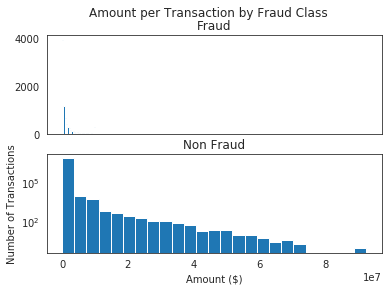

In [61]:
##investigate Amount and its relationship to isFraud
###First distributions/historgrams of amount by isFraud and is non fraud

fraud = data[data['isfraud']==1] #create subset of data 
normal = data[data['isfraud']==0] #create subset of data 


f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Amount per Transaction by Fraud Class')
bins= 25
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Non Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
# plt.xlim((0, 20000))
plt.yscale('log')
plt.show();




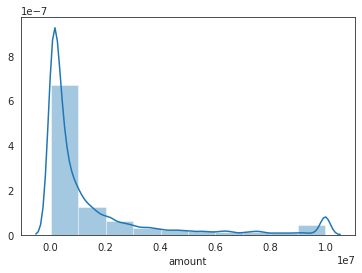

In [62]:
###fraud histogram deeper dive
sns.distplot(fraud.amount, bins = 10) # Use bins to control the intervals

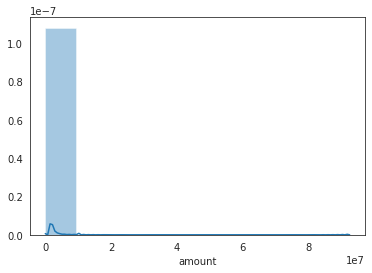

In [63]:
###fraud histogram deeper dive
sns.distplot(normal.amount, bins = 10) # Use bins to control the intervals

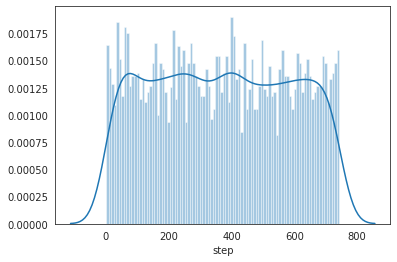

In [64]:
###fraud histogram deeper dive based on steps to see if there is a pattern
sns.distplot(fraud.step, bins = 92) # Use bins to control the intervals

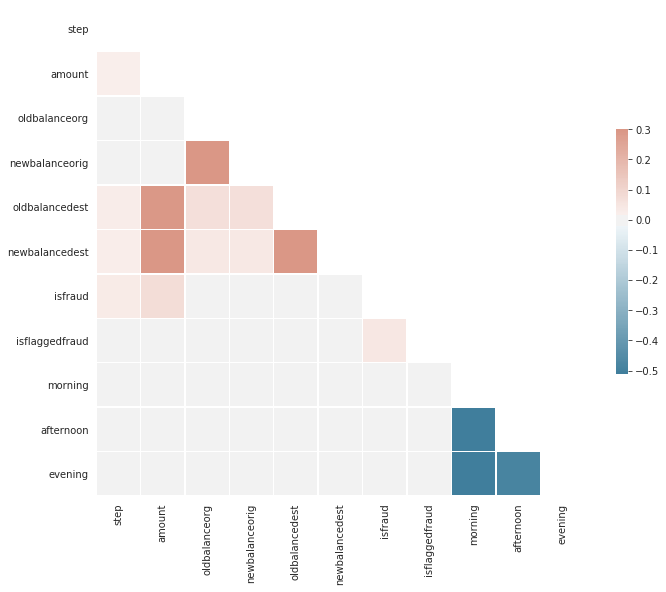

In [65]:
###plot out the correlation relationships 
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


###notice begginning and ending balances when looking at same Org or Dest have high relationships - deeper dive required

Feature Engineering and Preprocessing

In [66]:
%%time
###feature extracton and preprocessing
df = data.copy()

###flag for same Org and Dist per transaction or not  - dummy variable - one hot encoding
df['OrigCust']=df['nameorig'].apply(lambda x: 1 if str(x).find('C')==0 else 0)
df['DestCust']=df['namedest'].apply(lambda x: 1 if str(x).find('C')==0 else 0)

###flag for the transfer and cashout types only as those were where fraud only occured - dummy variable - one hot encoding
df['TRANSFER']=df['type'].apply(lambda x: 1 if x=='TRANSFER' else 0)
df['CASH_OUT']=df['type'].apply(lambda x: 1 if x=='CASH_OUT' else 0)

###same orginator as destination variable
df['sameorigdest']=df['nameorig'] == df['namedest']
df['sameorigdest']=df['sameorigdest'].apply(lambda x: 1 if x==False else 0)

CPU times: user 12.1 s, sys: 666 ms, total: 12.8 s
Wall time: 12.8 s


In [67]:
###drop duplicates, if any
df=df.drop_duplicates()


In [68]:
df.head()

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,...,afternoon,evening,OrigCust,DestCust,TRANSFER,CASH_OUT,sameorigdest
0,1,PAYMENT,15266.05,C1928621590,13679.0,0.00,M1016162524,...,0,0,1,0,0,0,1
1,1,PAYMENT,2141.82,C540923243,41643.0,39501.18,M244297136,...,0,0,1,0,0,0,1
2,1,PAYMENT,5323.28,C1799424291,22141.0,16817.72,M1472012329,...,0,0,1,0,0,0,1
3,1,DEBIT,4444.35,C1184694332,10229.0,5784.65,C611572016,...,0,0,1,1,0,0,1
4,1,CASH_OUT,289326.88,C1626529981,39689.0,0.00,C1076835071,...,0,0,1,1,0,1,1


In [69]:
pd.crosstab(df.sameorigdest, df.isfraud) ###confirms there are no transctions within the same orig and dest

isfraud,0,1
sameorigdest,,
1,6354407,8213


In [70]:
####calculate discrepanies in balances
df['OrigAmountDiff'] = (abs(df.oldbalanceorg-df.newbalanceorig)-df.amount)
df['DestAmountDiff'] = (abs(df.oldbalancedest-df.newbalancedest)-df.amount)

In [71]:
df.head()

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,...,OrigCust,DestCust,TRANSFER,CASH_OUT,sameorigdest,OrigAmountDiff,DestAmountDiff
0,1,PAYMENT,15266.05,C1928621590,13679.0,0.00,M1016162524,...,1,0,0,0,1,-1.587050e+03,-15266.05
1,1,PAYMENT,2141.82,C540923243,41643.0,39501.18,M244297136,...,1,0,0,0,1,-4.547474e-13,-2141.82
2,1,PAYMENT,5323.28,C1799424291,22141.0,16817.72,M1472012329,...,1,0,0,0,1,-9.094947e-13,-5323.28
3,1,DEBIT,4444.35,C1184694332,10229.0,5784.65,C611572016,...,1,1,0,0,1,0.000000e+00,19059.95
4,1,CASH_OUT,289326.88,C1626529981,39689.0,0.00,C1076835071,...,1,1,0,1,1,-2.496379e+05,8391.14


In [72]:
###drop unnecessary data
droplist=['isflaggedfraud', 'type','namedest','nameorig', 'sameorigdest']

In [81]:
xgb_data = df.drop(labels=droplist,axis=1)

In [82]:

###reorder data for isFraud to first colums
col_name ='isfraud'
first_col = xgb_data.pop(col_name)

xgb_data.insert(0,col_name, first_col)

xgb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6362620 entries, 0 to 6365560
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   isfraud         int64  
 1   step            int64  
 2   amount          float64
 3   oldbalanceorg   float64
 4   newbalanceorig  float64
 5   oldbalancedest  float64
 6   newbalancedest  float64
 7   morning         int64  
 8   afternoon       int64  
 9   evening         int64  
 10  OrigCust        int64  
 11  DestCust        int64  
 12  TRANSFER        int64  
 13  CASH_OUT        int64  
 14  OrigAmountDiff  float64
 15  DestAmountDiff  float64
dtypes: float64(7), int64(9)
memory usage: 825.2 MB


In [83]:
###Apply MinMaxScaler to dataset

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1), copy=True)
scaler.fit(xgb_data)

scaled_xgb_data = pd.DataFrame(scaler.transform(xgb_data), index=xgb_data.index, columns=xgb_data.columns)


scaled_xgb_data

,isfraud,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,...,evening,OrigCust,DestCust,TRANSFER,CASH_OUT,OrigAmountDiff,DestAmountDiff
0,0.0,0.0,0.000165,0.000230,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.999983,0.116256
1,0.0,0.0,0.000023,0.000699,0.000797,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.116409
2,0.0,0.0,0.000058,0.000372,0.000339,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.116372
3,0.0,0.0,0.000048,0.000172,0.000117,0.000073,0.000007,...,0.0,0.0,1.0,0.0,0.0,1.000000,0.116656
4,0.0,0.0,0.003130,0.000666,0.000000,0.000059,0.000895,...,0.0,0.0,1.0,0.0,1.0,0.997300,0.116531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6365556,1.0,1.0,0.003674,0.005701,0.000000,0.000000,0.000954,...,0.0,0.0,1.0,0.0,1.0,1.000000,0.116434
6365557,1.0,1.0,0.068272,0.105923,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,1.0,0.0,1.000000,0.042948
6365558,1.0,1.0,0.068272,0.105923,0.000000,0.000192,0.017912,...,0.0,0.0,1.0,0.0,1.0,1.000000,0.116434
6365559,1.0,1.0,0.009195,0.014265,0.000000,0.000000,0.000000,...,0.0,0.0,1.0,1.0,0.0,1.000000,0.106537


In [86]:
scaled_xgb_data.head()

,isfraud,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,...,evening,OrigCust,DestCust,TRANSFER,CASH_OUT,OrigAmountDiff,DestAmountDiff
0,0,0.0,0.000165,0.000230,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.999983,0.116256
1,0,0.0,0.000023,0.000699,0.000797,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.116409
2,0,0.0,0.000058,0.000372,0.000339,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.116372
3,0,0.0,0.000048,0.000172,0.000117,0.000073,0.000007,...,0.0,0.0,1.0,0.0,0.0,1.000000,0.116656
4,0,0.0,0.003130,0.000666,0.000000,0.000059,0.000895,...,0.0,0.0,1.0,0.0,1.0,0.997300,0.116531


In [85]:
scaled_xgb_data['isfraud'] = scaled_xgb_data['isfraud'].astype(int) ##make target variable non-continuous

In [88]:
####Send raw data and processed data to S3
scaled_xgb_data.to_csv( "preprocessedData.csv")

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'rawdata/rawdata.csv')).upload_file('full_data.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'preprocessed/preprocessed.csv')).upload_file('preprocessedData.csv')


In [97]:
###send preprocessing file to folder
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'preprocessed/preprocessed.py')).upload_file('ExplanatoryAnalysisandPreprocessing.ipynb')